In [12]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import neighbors
from cv_wrappers_kNN import cv_knn
from common_tools import plot_roc_auc
plt.style.use('seaborn-ticks')
%matplotlib inline

In [13]:
df_train = pd.read_csv('input/cybersecurity_training.csv', sep='|', index_col=0)
df_test = pd.read_csv('input/cybersecurity_test.csv', sep='|', index_col=0)

# Select target variable
target = 'notified'

In [14]:
# Read the models

# with open("output/models/model_RF_1.p", "rb") as fp:
#     model_RF_1 = pickle.load(fp)

with open("output/models/model_RF_2.p", "rb") as fp:
    model_RF_2 = pickle.load(fp)

with open("output/models/model_RF_3.p", "rb") as fp:
    model_RF_3 = pickle.load(fp)

with open("output/models/model_xgb_1.p", "rb") as fp:
    model_xgb_1 = pickle.load(fp)

with open("output/models/model_xgb_2.p", "rb") as fp:
    model_xgb_2 = pickle.load(fp)

with open("output/models/model_xgb_4.p", "rb") as fp:
    model_xgb_4 = pickle.load(fp)

In [15]:
# Create new variables from results to build new model and make predictions
res2plot = []
pred_names = []
true = df_train[target].sort_index()
for result in [model_RF_2, model_RF_3, model_xgb_2, model_xgb_1,  model_xgb_4]:
    # create a prediction vector by creating a series of pandas, and then sort the index
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    # Let's add a prediction column based on the name from the file and
    # let's clean up the model names to eliminate spaces and get rid of unnecessary components
    clean_name = (result['name']).replace("-", "_")
    pred_names.append(f"pred_{clean_name}")
    df_train[f"pred_{clean_name}"] = pred
    res2plot.append((true, pred, result["name"]))

#### Compare the latest models.

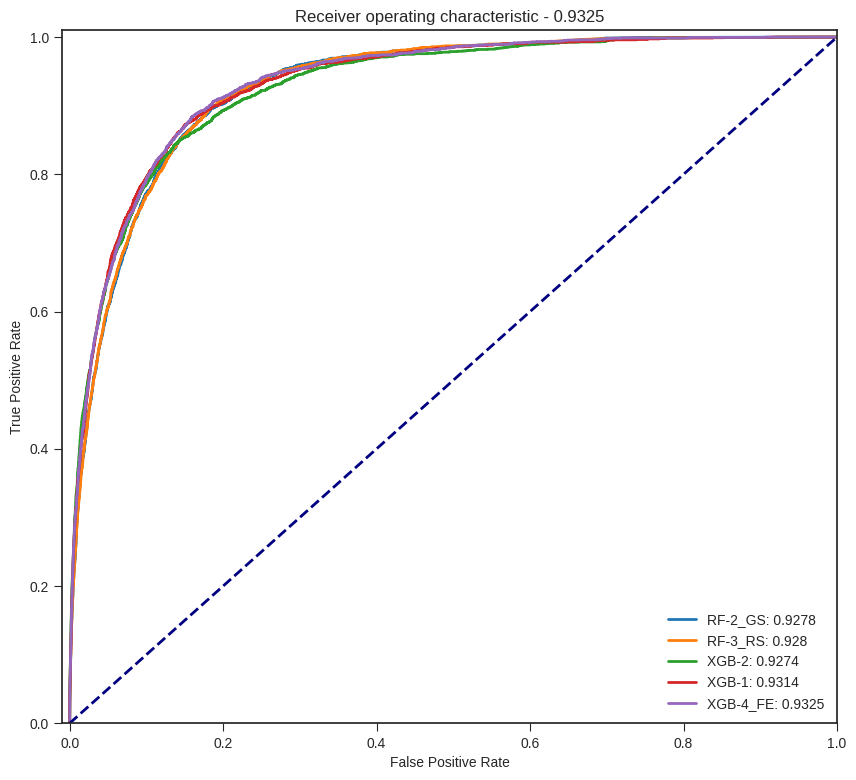

In [16]:
plot_roc_auc(res2plot)

We can see difference in predictions in different models

In [46]:
df_train[pred_names].sample(10)

,pred_RF_2_GS,pred_RF_3_RS,pred_XGB_2,pred_XGB_1,pred_XGB_4_FE
alert_ids,,,,,
kvg,0.000000,0.000000,0.001201,0.000292,0.000432
oKU,0.000000,0.000000,0.000945,0.000183,0.000295
TqP,0.012396,0.004324,0.003088,0.000987,0.001654
DTQ,0.298756,0.285655,0.733986,0.481959,0.537144
DjB,0.169060,0.165293,0.018870,0.047285,0.035984
lXc,0.009042,0.006486,0.003791,0.001299,0.002390
bFw,0.076581,0.075613,0.018714,0.011201,0.012800
Qts,0.011537,0.007944,0.000291,0.000647,0.000512
plN,0.015471,0.011058,0.001018,0.001186,0.002547


On the one hand, we see some correlation, but at the same time we also see some diversity.

In [47]:
df_train[pred_names].corr()

,pred_RF_2_GS,pred_RF_3_RS,pred_XGB_2,pred_XGB_1,pred_XGB_4_FE
pred_RF_2_GS,1.000000,0.995395,0.795527,0.818254,0.803205
pred_RF_3_RS,0.995395,1.000000,0.797652,0.820498,0.805371
pred_XGB_2,0.795527,0.797652,1.000000,0.956668,0.960745
pred_XGB_1,0.818254,0.820498,0.956668,1.000000,0.972337
pred_XGB_4_FE,0.803205,0.805371,0.960745,0.972337,1.000000


We can see which model how often gives the highest and lowest value. This definitely confirms our observation about how the results are really diverse. No one model always gives higher or lower predictions than the others.

In [48]:
print(df_train[pred_names].idxmax(axis=1).value_counts())
print(df_train[pred_names].idxmin(axis=1).value_counts())

pred_RF_2_GS     15333
pred_RF_3_RS     14498
pred_XGB_2        4333
pred_XGB_1        2683
pred_XGB_4_FE     2580
dtype: int64
pred_XGB_2       14327
pred_XGB_1        9159
pred_RF_2_GS      8818
pred_XGB_4_FE     4904
pred_RF_3_RS      2219
dtype: int64


Let's check the averaged results of these models

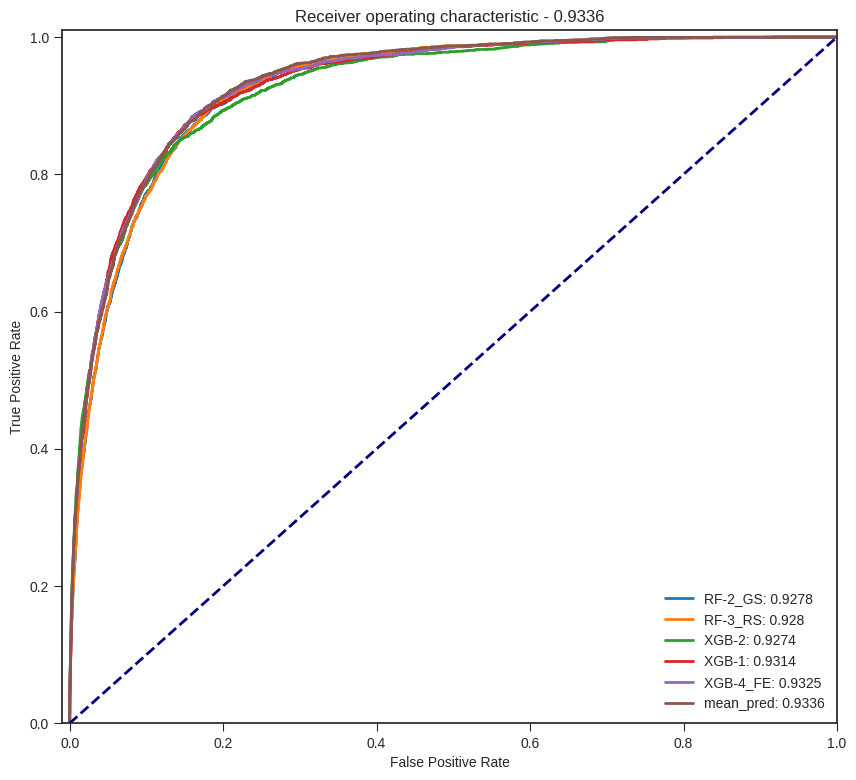

In [17]:
df_train["pred_mean"] = df_train[pred_names].mean(axis=1)
res2plot.append((true, df_train["pred_mean"].sort_index().tolist(), "mean_pred"))
plot_roc_auc(res2plot)

As you can see, by using a simple average of past predictions, we obtained by far the best result. The strength of the prediction model based on the average of only three components is greater than that of all components. This result is sensational considering that we simply counted the average. Despite the fact that some models were already weaker and others stronger, the prediction of each model entered the new forecast with the same weight.

## Stacking

### Logistic Regression

Instead of counting the average or selecting weights, we can see what happens when we use the predictions from previous models as variables in a logistic regression.
Note that the variables will be highly correlated, so logistic regression may not be the best algorithm for this.

In [53]:
mod = sm.GLM.from_formula(formula="notified ~ "+"+".join(pred_names),
                          data=df_train, family=sm.families.Binomial())
res = mod.fit()
preds_stack = res.predict()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               notified   No. Observations:                39427
Model:                            GLM   Df Residuals:                    39421
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5551.8
Date:                Thu, 22 Sep 2022   Deviance:                       11104.
Time:                        15:26:05   Pearson chi2:                 2.75e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1476
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.3388      0.044    -97.587      0.000      -4.426      -4.252
pred_RF_2_GS      7.3218      1.572      4.657      0.000       4.240      10.403
pred_RF_3_RS      4.9173      1.586      3.100      0.002       1.809       8.026
pred_XGB_2        4.0749      0.498      8.181      0.000       3.099       5.051
pred_XGB_1       -4.1009      0.647     -6.335      0.000      -5.370      -2.832
pred_XGB_4_FE    -0.5580      0.664     -0.841      0.401      -1.859       0.743
=================================================================================
"""

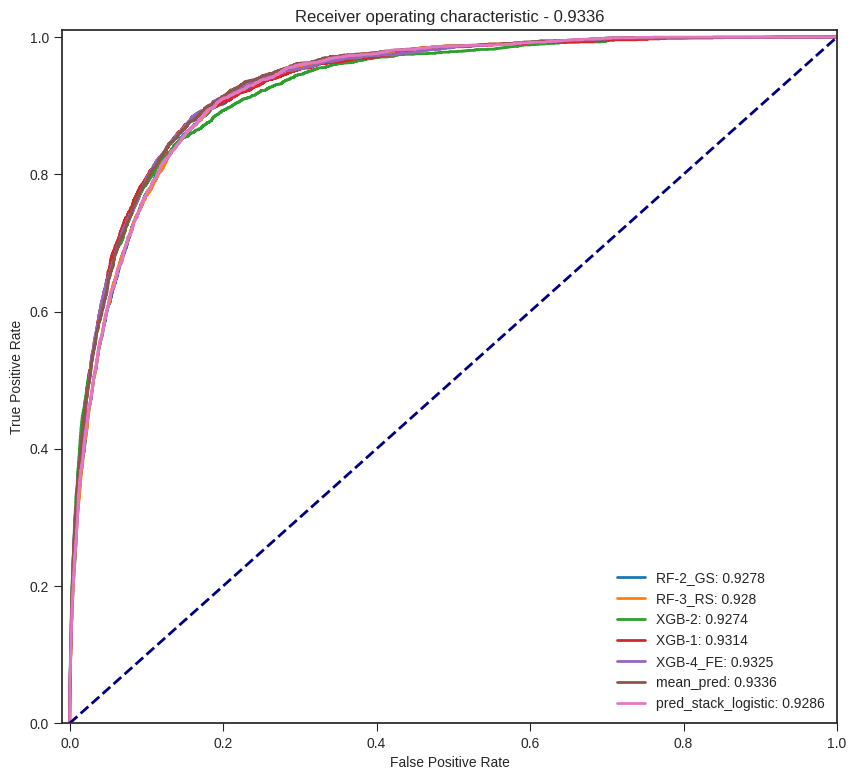

In [55]:
df_train["pred_stack_logistic"] =  preds_stack
res2plot.append((true, df_train["pred_stack_logistic"].sort_index().tolist(), "pred_stack_logistic"))
plot_roc_auc(res2plot)

We received worse results compared to the usual average.

For example, We can manually select weights, 3, 2, 1 for each model.

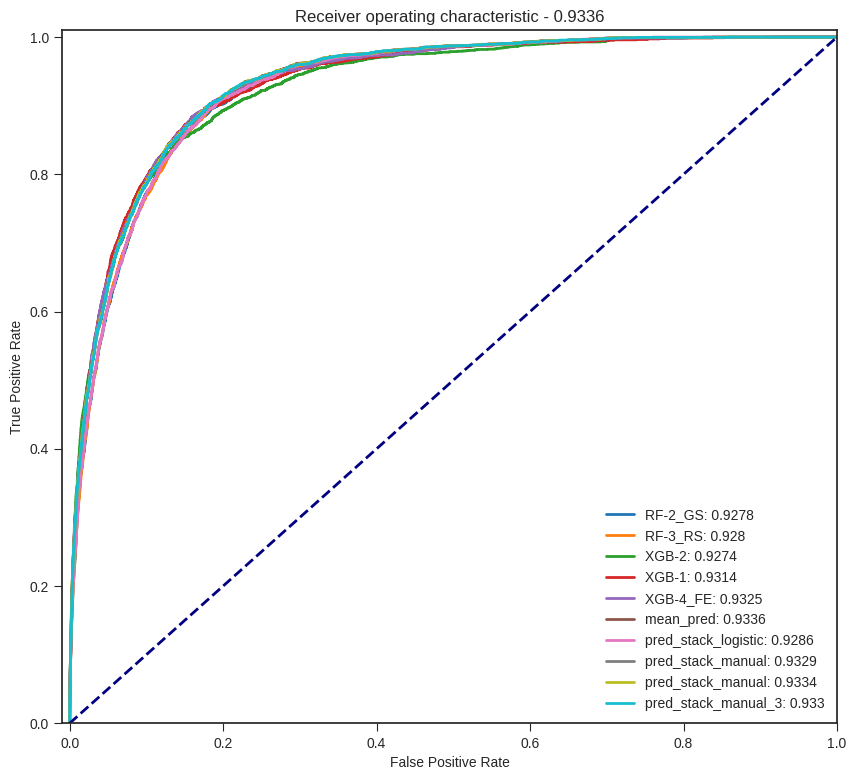

In [59]:
df_train["pred_stack_manual_3"] = (1*df_train["pred_RF_2_GS"] + 3*df_train["pred_RF_3_RS"] + 1*df_train["pred_XGB_1"] + 1*df_train["pred_XGB_2"] + 3*df_train["pred_XGB_4_FE"])/9
res2plot.append((true, df_train["pred_stack_manual_3"].sort_index().tolist(), "pred_stack_manual_3"))
plot_roc_auc(res2plot)

We received good results, but worse than the usual average

### kNN

We can check how stacking with KNN would perform. We will estimate several models.

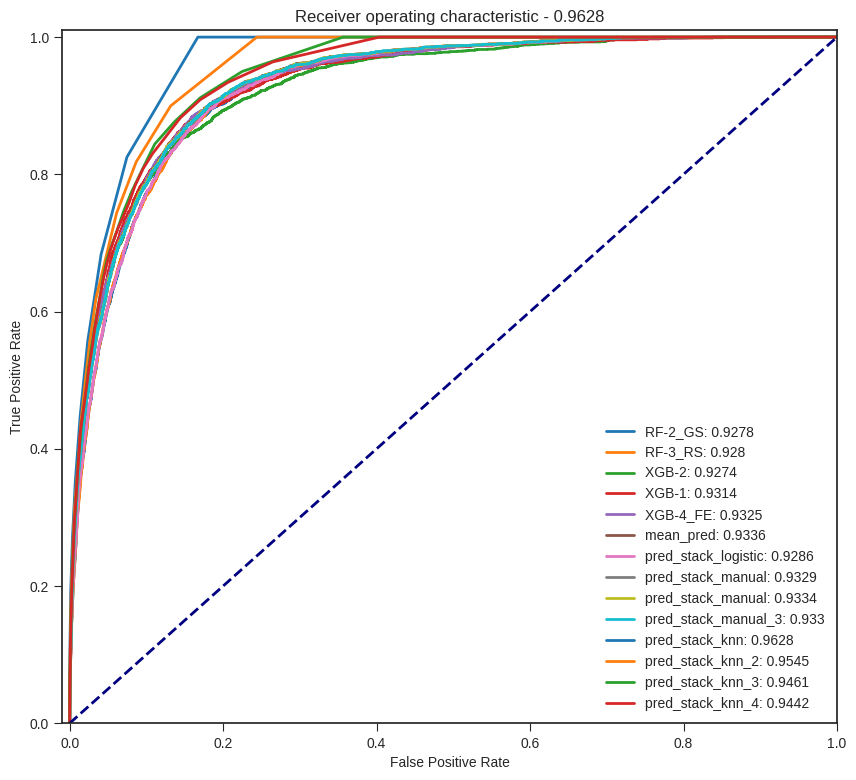

In [65]:
clf = neighbors.KNeighborsClassifier(n_neighbors=70, n_jobs=-1, p=2).fit(df_train[pred_names], df_train[target])
preds_stack_knn = clf.predict_proba(df_train[pred_names])[:,1]
df_train["pred_stack_knn_4"] = preds_stack_knn
res2plot.append((true, df_train["pred_stack_knn_4"].sort_index().tolist(), "pred_stack_knn_4"))
# Wywołujemy funkcję do rysowania
plot_roc_auc(res2plot)

We can see what overtraining in stacking is and when the stacking model is trained on the whole sample, rather than cross-validating.
The smaller the k, the better the model hypothetically fits the data. But this is just an illusion. The model estimates parameters for the entire learning set, so as k decreases, it simply learns the model by heart.

Let's use Cross Validation and Grid Search to try to find the best parameters and model.

KNeighborsClassifier(n_jobs=-1, n_neighbors=400)
Train AUC: 0.9383558254800106 Valid AUC: 0.9298762740434408
KNeighborsClassifier(n_jobs=-1, n_neighbors=400)
Train AUC: 0.9366917060549054 Valid AUC: 0.9390647032716113
KNeighborsClassifier(n_jobs=-1, n_neighbors=400)
Train AUC: 0.9389128543551194 Valid AUC: 0.9278296528776511
KNeighborsClassifier(n_jobs=-1, n_neighbors=400)
Train AUC: 0.9367863510933515 Valid AUC: 0.938047937924285
KNeighborsClassifier(n_jobs=-1, n_neighbors=400)
Train AUC: 0.9384114931933605 Valid AUC: 0.9303681733518852
Train mean: 0.9378316460353494, Test mean: 0.9330373482937746, Diff: 0.0047942977415748045
KNeighborsClassifier(n_jobs=-1, n_neighbors=425)
Train AUC: 0.9382638946695405 Valid AUC: 0.9302426247735233
KNeighborsClassifier(n_jobs=-1, n_neighbors=425)
Train AUC: 0.9364124444985594 Valid AUC: 0.9388646441925812
KNeighborsClassifier(n_jobs=-1, n_neighbors=425)
Train AUC: 0.9387283331028704 Valid AUC: 0.9280513421796516
KNeighborsClassifier(n_jobs=-1, n_neig

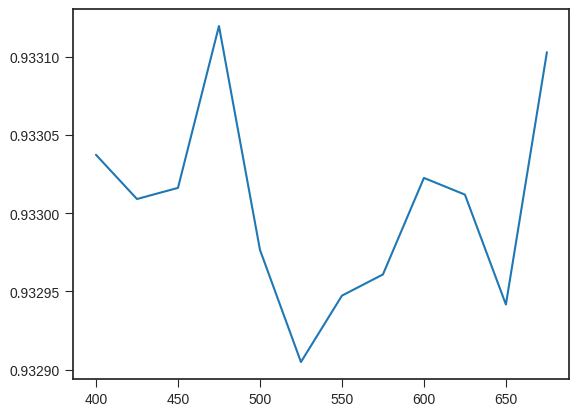

In [10]:
rang = range(400, 700, 25)
results = []
for x in rang:
    trainResults, testResults, predictions, indices = cv_knn(df_train, target, pred_names, random_state=2022, debug=True, mlflow_tracking= True, exp_name="exp_5_stacking", n_neighbors=x, n_jobs=-1, p=2)
    print(f'Train mean: {np.mean(trainResults)}, Test mean: {np.mean(testResults)}, Diff: {np.mean(trainResults) - np.mean(testResults)}')
    results.append(np.mean(testResults))

plt.plot(list(rang), results)
plt.show()

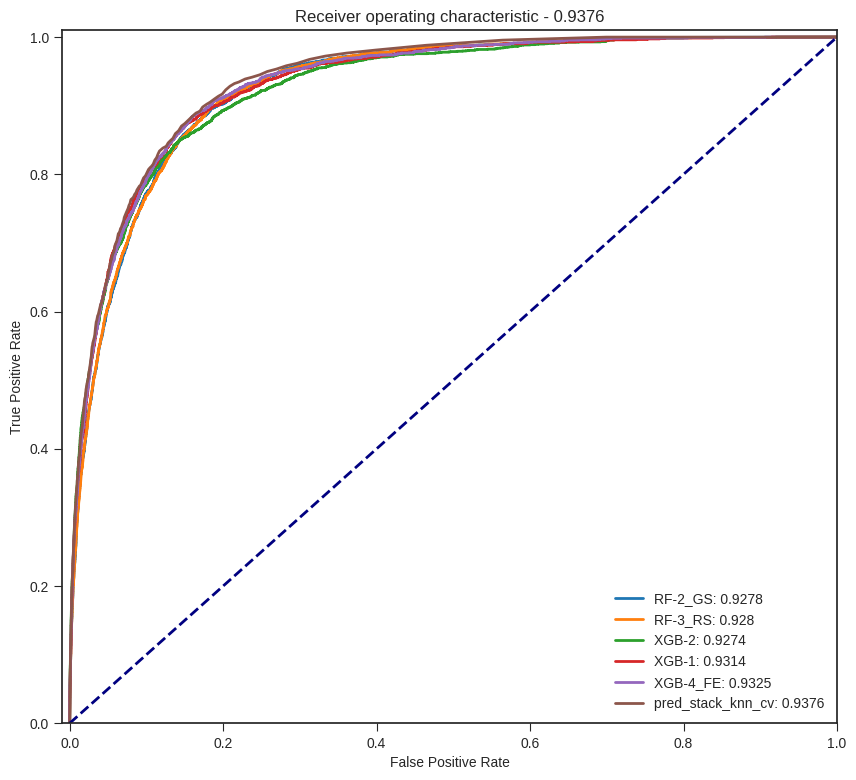

In [11]:
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(n_neighbors=475, n_jobs=-1, p=2).fit(df_train[pred_names], df_train[target])
predsStack2 = clf.predict_proba(df_train[pred_names])[:,1]
df_train["pred_stack_knn_cv"] = predsStack2
res2plot.append((true, df_train["pred_stack_knn_cv"].sort_index().tolist(), "pred_stack_knn_cv"))
# Wywołujemy funkcję do rysowania
plot_roc_auc(res2plot)

Managed to get the best results so far